### Two connected nodes for the Hopf model

In [1]:
import os
import sys

sys.path.insert(1, os.path.expanduser("~/projects/phase_amplitude_encoding/"))

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.filter import filter_data
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from tqdm import tqdm

from src.models import simulate, simulate_delayed

/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.config.update("jax_platform_name", "cpu")

#### Functions

In [55]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a, idx, axis=axis)


def miller_madow_correction(x, y, mi_hat):
    """
    Apply Miller-Madow bias correction to a binned MI estimate.

    Parameters
    ----------
    x, y : array-like, int bins (same length)
    mi_hat : float, raw MI estimate (bits)
    """
    N = len(x)
    kx = len(np.unique(x))
    ky = len(np.unique(y))
    kxy = len(np.unique(list(zip(x, y))))
    correction = (kx + ky - kxy - 1) / (2 * N * np.log(2))
    print(correction)
    return mi_hat + correction


def panzeri_treves_correction(x, y, mi_hat):
    """
    Panzeri–Treves bias correction for binned MI (in bits).

    x, y : arrays of same length
        Discretized samples (e.g., responses and stimuli labels)
    mi_hat : float
        Raw MI estimate (in bits)
    """
    N = len(x)
    Qx = len(np.unique(x))
    Qy = len(np.unique(y))
    correction = ((Qx - 1) * (Qy - 1)) / (2 * N * np.log(2))
    return mi_hat - correction


def digitize_equiprobable(data, N):
    """
    Coarse-grain continuous data into N equiprobable bins (quantile-based).
    Each sample is replaced by the bin's representative (mean) value.

    Parameters:
        data (array-like): input float data (any shape)
        N (int): number of bins

    Returns:
        np.ndarray: data replaced by bin representative values
        np.ndarray: bin edges used
    """
    data = jnp.asarray(data)

    # Compute quantile-based bin edges
    quantiles = jnp.linspace(0, 1, N + 1)
    bin_edges = jnp.quantile(data, quantiles)

    # Digitize using those edges
    bin_idx = jnp.digitize(data, bin_edges, right=False)

    return bin_idx, bin_edges

#### Simulation parameters

In [38]:
Nareas = 2
ntrials = 500
fsamp = 1 / 1e-3

time = np.arange(-4, 2, 1 / fsamp)
beta = 1.5
Npoints = len(time)
decim = 10

C = np.array([[0, 1], [0, 0]]).T

f = 40

In [39]:
s = 16 / (2 * np.pi * f)

time_start = 0
time_end = 1.0
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))
coupling = np.zeros_like(time)
coupling[ind] = gaussian

# Coupling strength array (linearly spaced from 1 to 100)
CS = np.linspace(1, 100, ntrials)
seeds = np.random.randint(0, 100000, ntrials)

In [40]:
simulate_loop = jax.vmap(
    simulate, in_axes=(None, 0, None, None, None, None, None, None, 0, None, None, None)
)

In [41]:
coupling = CS[:, None] * coupling

In [42]:
out = simulate_loop(
    C,
    coupling,
    40,
    0,
    fsamp,
    beta,
    Npoints,
    None,
    seeds,
    "cpu",
    decim,
    "both",
)

In [43]:
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(range(ntrials), ["x", "y"], time[::decim]),
).sel(times=slice(-0.5, 1))

In [44]:
"""
fig = plt.figure(figsize=(8 / 2.54, 5 / 2.54))
ax = plt.subplot(111)
for i in range(Nareas):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3))
plt.xlabel("Time [s]", fontsize=12)
# plt.legend(["Sender", "Receiver"], frameon=False, fontsize=12)
plt.xlim(-2, 2)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.savefig("figures/hopf_time_series.png", bbox_inches="tight")
""";

In [56]:
from jax import custom_derivatives, dtypes, lax
from jax._src.lax.lax import _const as _lax_const
from jax._src.numpy.util import promote_args_inexact, promote_dtypes_inexact
from jax.typing import ArrayLike


def xlogy(x: ArrayLike, y: ArrayLike):
    """Compute x*log(y), returning 0 for x=0.

    JAX implementation of :obj:`scipy.special.xlogy`.

    This is defined to return zero when :math:`(x, y) = (0, 0)`, with a custom
    derivative rule so that automatic differentiation is well-defined at this point.

    Args:
      x: arraylike, real-valued.
      y: arraylike, real-valued.

    Returns:
      array containing xlogy values.

    See also:
      :func:`jax.scipy.special.xlog1py`
    """
    # Note: xlogy(0, 0) should return 0 according to the function documentation.
    x, y = promote_args_inexact("xlogy", x, y)
    x_ok = x != 0.0
    return jnp.where(x_ok, lax.mul(x, lax.log(y)), jnp.zeros_like(x))


def entrBin(x: ArrayLike, deltas: ArrayLike):
    r"""The entropy function

  JAX implementation of :obj:`scipy.special.entr`.

  .. math::

     \mathrm{entr}(x) = \begin{cases}
       -x\log(x) & x > 0 \\
       0 & x = 0\\
       -\infty & \mathrm{otherwise}
     \end{cases}

  Args:
    x: arraylike, real-valued.

  Returns:
    array containing entropy values.

  See also:
    - :func:`jax.scipy.special.kl_div`
    - :func:`jax.scipy.special.rel_entr`
  """
    (x,) = promote_args_inexact("entr", x)
    if dtypes.issubdtype(x.dtype, np.complexfloating):
        raise ValueError("entr does not support complex-valued inputs.")
    return lax.select(
        lax.lt(x, _lax_const(x, 0)),
        lax.full_like(x, -np.inf),
        lax.neg(xlogy(x, x / deltas)),
    )


def mutualInformationBin(x, y, nx_bins, ny_bins):

    x, bin_edges_x = digitize_equiprobable(x, nx_bins)
    y, bin_edges_y = digitize_equiprobable(y, ny_bins)

    N = x.shape[1]

    delta_bin_x = jnp.diff(bin_edges_x)
    delta_bin_y = jnp.diff(bin_edges_y)
    
    # Entropy of X
    uniques, counts = jnp.unique(
        x, return_counts=True, size=nx_bins, axis=1, fill_value=0
    )
    probs = counts / N

    Hx = entrBin(probs, delta_bin_x).sum() / np.log(
        2
    )  
    
    # Entropy of Y
    uniques, counts = jnp.unique(
        y, return_counts=True, size=ny_bins, axis=1, fill_value=0
    )
    probs = counts / N

    Hy = entrBin(probs, delta_bin_y).sum() / np.log(
        2
    )  

    # Entropy of XY
    xy = jnp.concatenate((x, y), axis=0)
    uniques, counts = jnp.unique(
        xy, return_counts=True, size=nx_bins * ny_bins, axis=1, fill_value=0
    )
    probs = counts / N
    delta = delta_bin_x[uniques[0]] * delta_bin_y[uniques[1]]
    Hxy = entrBin(probs, delta).sum() / np.log(
        2
    ) 

    return Hx + Hy - Hxy

mutualInformationBin_jax = jax.vmap(mutualInformationBin, in_axes=(2, 2, None, None))

(-0.25, 1.0)

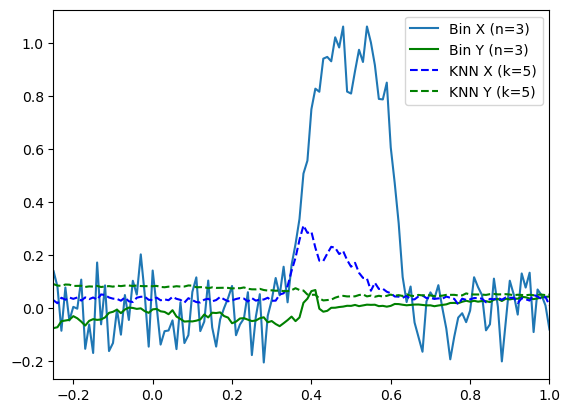

In [78]:
z = data[:, 0] * np.conj(data[:, 1])

A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

I = mutualInformationBin_jax(A[None], labels[None], 3, ntrials)
plt.plot(data.times, I - np.log2(3))

I = mutualInformationBin_jax(dphi[None], labels[None], 3, ntrials)
plt.plot(data.times, I - np.log2(3), "g")

plt.plot(data.times, I_S_R1, "b--")
plt.plot(data.times, I_S_R2, "g--")

plt.legend(["Bin X (n=3)", "Bin Y (n=3)", "KNN X (k=5)", "KNN Y (k=5)"])

plt.xlim(-.25, 1)

In [66]:
np.log2(3)

1.584962500721156

In [343]:
x = np.random.normal(0, 1, (1, 5000))
y = np.random.normal(0, 1, (1, 5000))


mutualInformationBin(x, y, 3 ,3)

Array(0.02383852, dtype=float64)

In [45]:
mi_fcn = get_mi("knn")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None))

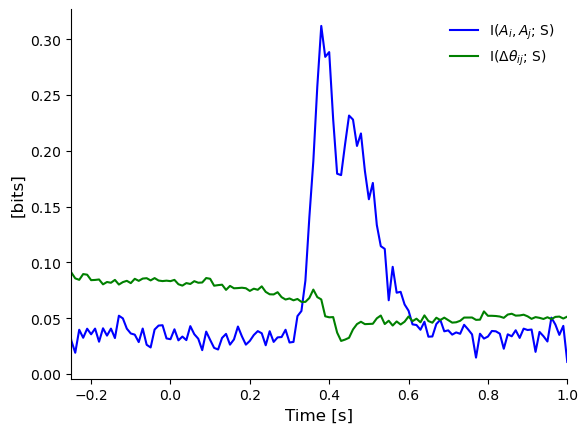

In [48]:
labels = np.tile(np.expand_dims(np.arange(0, ntrials), 1), data.sizes["times"])
#labels = np.random.uniform(0, 100, (ntrials, data.shape[-1]))

z = data[:, 0] * np.conj(data[:, 1])

A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

#A = digitize_equiprobable(A, 100)
#dphi = digitize_equiprobable(dphi, 100)

I_S_R1 = mi_fcn_time(A[None], labels[None], 5)
I_S_R2 = mi_fcn_time(dphi[None], labels[None], 5)

# I_S_R1_bias = np.mean([mi_fcn_time(A[None], shuffle_along_axis(labels, 0)[None]) for _ in tqdm( range(50) )], 0)
# I_S_R2_bias = np.mean([mi_fcn_time(dphi[None], shuffle_along_axis(labels, 0)[None]) for _ in tqdm( range(50) )], 0)


ax = plt.subplot(111)
plt.plot(data.times, I_S_R1, "b")
# plt.plot(data.times, I_S_R1_bias, "b--")

plt.plot(data.times, I_S_R2, "g")
# plt.plot(data.times, I_S_R2_bias, "g--")

# plt.plot(
#    time[(time >= -1) * (time <= 1)],
#    coupling[-1, (time >= -1) * (time <= 1)] / 100 * 4,
#    "k--",
# )

plt.legend(
    [
        r"I($A_{i}, A_{j}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
    ],
    frameon=False,
)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlim(-0.25, 1)
# plt.ylim(2.5, 5)
plt.savefig("figures/sample_encoding_evoked_potential.png", bbox_inches="tight")

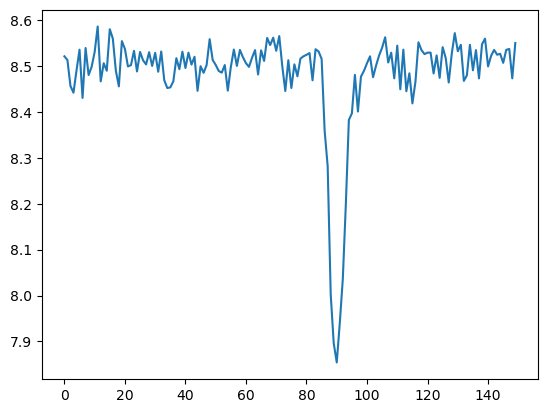

In [69]:
plt.plot(mi_fcn_time(A[None], shuffle_along_axis(labels, 0)[None]))

71.27057771495569


[None, None]

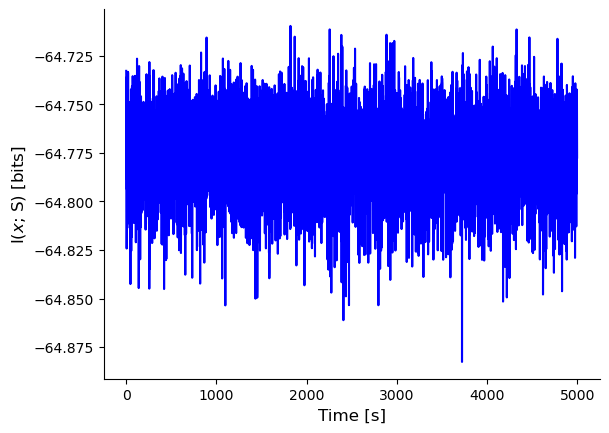

In [33]:
mi_fcn = get_mi("binning")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2))

ntrials = 500

x = np.random.normal(0, 1, size=(ntrials, 5000))
y = np.random.normal(0, 1, size=(ntrials, 5000))


labels = np.tile(np.expand_dims(np.arange(0, ntrials, dtype=int), 1), x.shape[-1])

nbins = 100
x = digitize_equiprobable(x, nbins)
y = digitize_equiprobable(labels, nbins)


I_S_R1 = mi_fcn_time(x[None], labels[None])

ax = plt.subplot(111)
plt.plot(panzeri_treves_correction(x, labels, I_S_R1), "b")

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel(r"I($x$; S) [bits]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

In [30]:
out = [
    mi_fcn_time(x[None], np.random.permutation(labels)[None]) for _ in tqdm(range(50))
]

100%|███████████████████████████████████| 50/50 [00:28<00:00,  1.76it/s]


In [31]:
np.mean(out, 0)

array([4.23004893, 4.24698023, 4.20779595, ..., 4.20738406, 4.26459471,
       4.20710503])

(-0.25, 1.0)

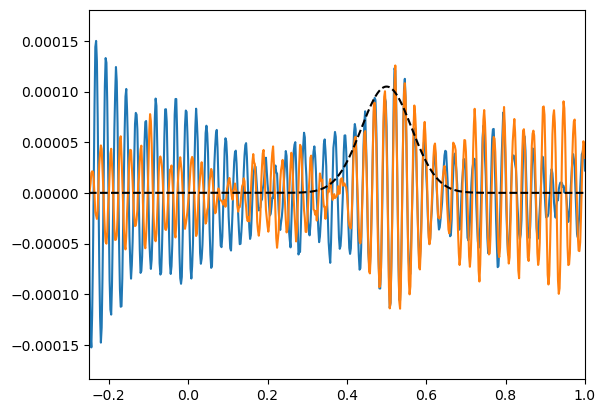

In [45]:
plt.plot(data.times, data[-1].real.T)
plt.plot(time, coupling[1] / 10000, "k--")

plt.xlim(-0.25, 1)

(-1.0, 1.0)

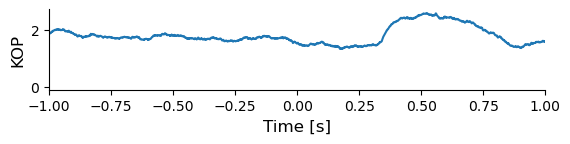

In [157]:
ax = plt.subplot(414)
plt.plot(data.times, np.abs(data.values.mean(1)).mean(0))
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("KOP", fontsize=12)
plt.xlim(-1, 1)

In [17]:
z = data.isel(roi=0) * np.conj(data.isel(roi=1))
A = np.abs(z).values
dphi = np.unwrap(np.angle(z))

In [69]:
A = digitize_equiprobable(A, 10)
dphi = digitize_equiprobable(dphi, 10)

In [70]:
labels = np.tile(np.expand_dims(CS, 1), data.sizes["times"])

[None, None]

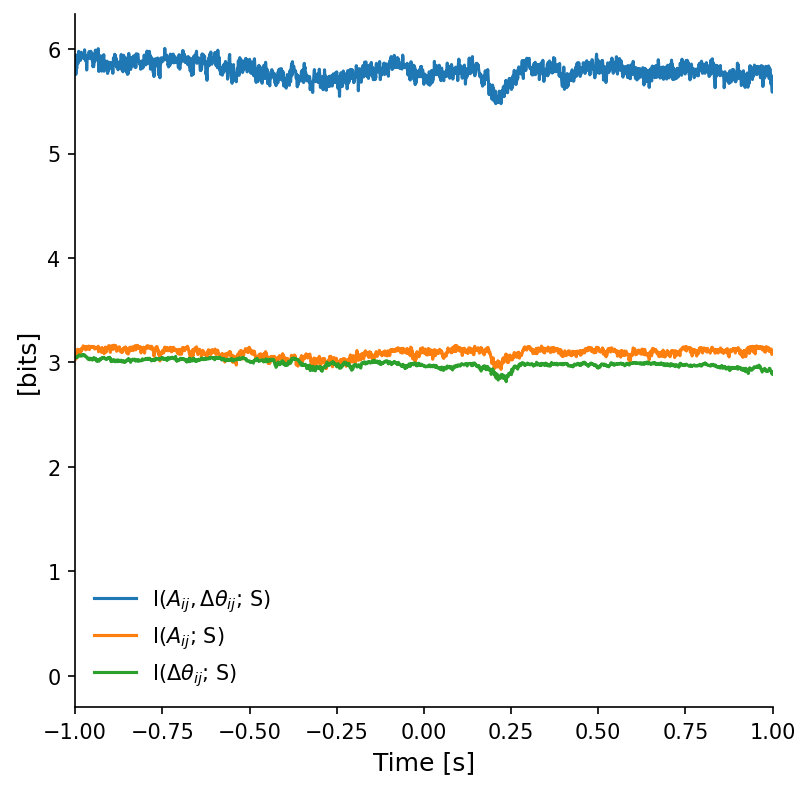

In [71]:
plt.figure(figsize=(6, 6), dpi=150)
ax = plt.subplot(111)

mi_fcn = get_mi("binning")

mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2))


mv = np.stack((A, dphi), axis=0)


plt.plot(data[-1].times, mi_fcn_time(mv, labels[None]))
plt.plot(data[-1].times, mi_fcn_time(A[None], labels[None]))
plt.plot(data[-1].times, mi_fcn_time(dphi[None], labels[None]))

plt.legend(
    [
        r"I($A_{ij}, \Delta\theta_{ij}$; S)",
        r"I($A_{ij}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
    ],
    frameon=False,
)
plt.xlim(-1, 1)
plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

#### Run a batch of simulations

In [ ]:
I_S_R1 = []
I_S_R2 = []
I_S_R1_R2 = []

a = -5
fsamp = 1 / 1e-4
decim = 1

if a >= 0:
    beta = 2.5
else:
    beta = 1e-4

for _ in tqdm(range(20)):

    seeds = np.random.randint(0, 100000, ntrials)

    out = simulate_loop(
        C,
        coupling,
        40,
        a,
        fsamp,
        beta,
        Npoints,
        None,
        seeds,
        "cpu",
        decim,
        "both",
    )

    stim = np.arange(ntrials)
    data = xr.DataArray(
        np.stack(out),
        dims=("trials", "roi", "times"),
        coords=(stim, ["x", "y"], time[::decim]),
    ).sel(times=slice(-2, 2))

    labels = np.tile(np.expand_dims(CS, 1), data.sizes["times"])
    z = data[:, 0] * np.conj(data[:, 1])
    A = np.abs(z).values
    dphi = np.unwrap(np.angle(z))
    mv = np.stack((A, dphi), axis=0)

    I_S_R1 += [mi_fcn_time(A[None], labels[None], False, True)]
    I_S_R2 += [mi_fcn_time(dphi[None], labels[None], False, True)]
    I_S_R1_R2 += [mi_fcn_time(mv, labels[None], False, True)]

 10%|███▌                                | 2/20 [02:39<25:43, 85.72s/it]

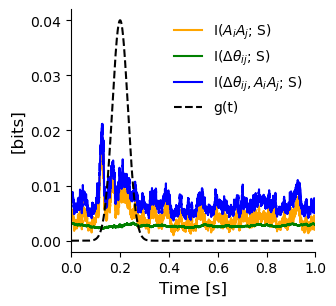

In [99]:
plt.figure(figsize=(8 / 2.54, 8 / 2.54))
ax = plt.subplot(111)
plt.plot(data.times, np.mean(I_S_R1, 0), "orange")
plt.plot(data.times, np.mean(I_S_R2, 0), "g")
plt.plot(data.times, np.mean(I_S_R1_R2, 0), "b")

plt.plot(
    time[(time >= 0) * (time <= 1)],
    coupling[-1, (time >= 0) * (time <= 1)] / 10000 * 4,
    "k--",
)

plt.legend(
    [
        "I($A_{i}A_{j}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
        r"I($\Delta\theta_{ij}, A_{i}A_{j}$; S)",
        "g(t)",
    ],
    frameon=False,
)

plt.xlabel("Time [s]", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlim(0, 1)
plt.savefig("figures/sample_encoding_evoked_potential.pdf", bbox_inches="tight")

In [100]:
I_S_R1 = np.mean(I_S_R1, 0)
I_S_R2 = np.mean(I_S_R2, 0)
I_S_R1_R2 = np.mean(I_S_R1_R2, 0)

In [101]:
red = np.minimum(I_S_R2, I_S_R1)
syn = I_S_R1_R2 - np.maximum(I_S_R2, I_S_R1)

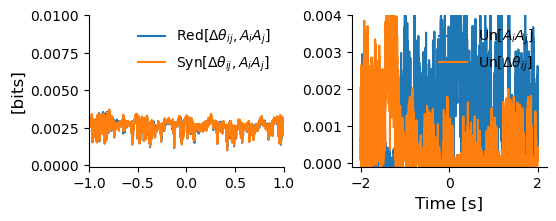

In [102]:
plt.figure(figsize=(15 / 2.54, 5 / 2.54))

ax = plt.subplot(121)
plt.plot(data.times, red)
plt.plot(data.times, syn)

plt.legend(
    [r"Red[$\Delta\theta_{ij}, A_{i}A_{j}$]", r"Syn[$\Delta\theta_{ij}, A_{i}A_{j}$]"],
    frameon=False,
)
plt.xlim(-1, 1)
plt.ylim(-0.0001, 0.01)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.ylabel("[bits]", fontsize=12)

ax = plt.subplot(122)
plt.plot(data.times, I_S_R1 - syn)
plt.plot(data.times, I_S_R2 - syn)
plt.ylim(-0.0001, 0.004)
# ax.set_yticklabels([])
plt.legend([r"Un[$A_{i}A_{j}$]", r"Un[$\Delta\theta_{ij}$]"], frameon=False)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]


plt.subplots_adjust(wspace=0.35)
plt.xlabel("Time [s]", fontsize=12)

plt.savefig("figures/red_syn_amp_vs_phase.pdf", bbox_inches="tight")